In [1]:
%matplotlib inline
from karabo_data.geometry2 import DSSC_Geometry

In [2]:
# Made up numbers!
quad_pos = [
    (-5, 140),
    (-5, -5),
    (130, -5),
    (130, 140),
]
path = 'dssc_geo_photometrology_simple_inverted.h5'

g = DSSC_Geometry.from_h5_file_and_quad_positions(path, quad_pos)

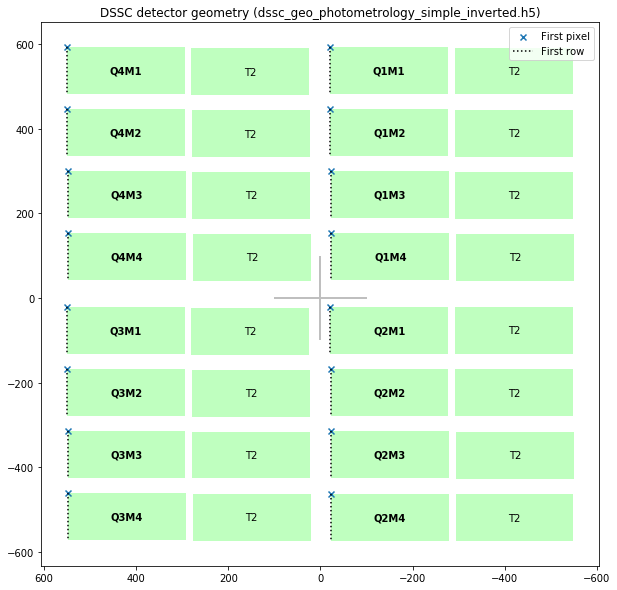

In [3]:
g.inspect()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
g.expected_data_shape

(16, 512, 128)

In [6]:
a = np.zeros(g.expected_data_shape)

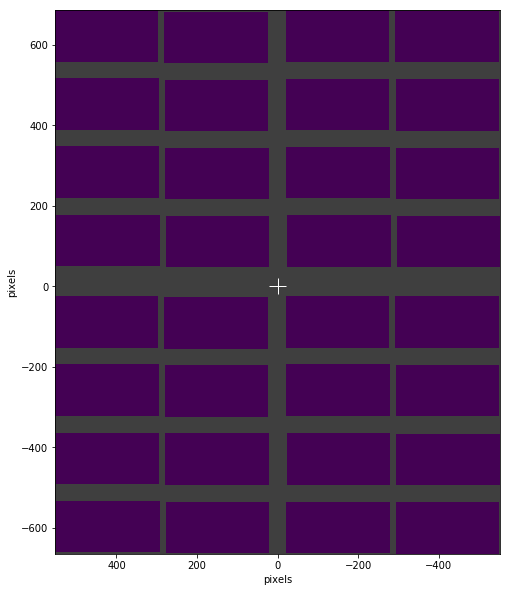

In [7]:
g.plot_data_fast(a);